# 10 Quick Tips for ODE Inference

## Introduction

This Python notebook accompanies the article "Ten quick tips for performing inference for differential equation models."

At the beginning of the notebook, we introduce a differential equation model of the spread of an infectious disease. We aim to fit the model to data of the Bombay plague epidemic. We illustrate each of the tips from the paper as they apply to this example inference problem.

## Model

Compartmental models of infectious disease spread assume that each member of the population is characterized by membership in one of some finite set of disease states representing susceptibility, recovery, death, or different types of infection with the disease.

In our model, we employ three states: $S$, representing _susceptibles_ who are liable to be infected with the disease; $I$, representing _infectious_ individuals who are infected and may spread the disease to other members of the population; and $R$, representing those who have _recovered_ from the disease. We also have a death compartment, $D$, to allow for the fact that some infected will die of the disease rather than recover.

We will develop a mathematical model by defining the rules according to which individuals move from one compartment to another in terms of a system of differential equations:

$$\frac{dS}{dt} = - \beta SI / N$$
$$\frac{dI}{dt} = \beta S I / N - \gamma I - \delta I $$
$$\frac{dR}{dt} = \gamma I $$
$$\frac{dD}{dt} = \delta I$$

This system of equations involves several unknown parameters---$\beta$, $\gamma$, and $\delta$---which describe the rates at which individuals move from one compartment to another. Additionally, $N$ represents the total population size, and we will always choose initial conditions such that $S + I + R + D = N$.

Fitting the model to data, and learning values of parameters such as $\beta$, $\gamma$, and $\delta$, is important for understanding the spread of an infectious disease outbreak.

The plague epidemic in Bombay, India resulted in thousands of deaths and over half of the population fleeing out of the city. In this Python notebook we will try to fit the SIRD model described above to the weekly deaths from the Bombay plague.

## Tip 1: Work with biologists to develop the model, and use mathematical analysis to understand it before trying to fit

In the version of the SIRD model given above, $\gamma$ describes the per capita rate at which infectious individuals recover from the disease, while $\delta$ is the per capita rate at which infectious individuals die.

These parameters are not necessarily convenient for inference. Biological knowledge of the disease instead is more informative of the probability of an infected person dying (rather than recovering), and the time spent infectious (before either dying or recovering). For these reasons, our first step is to rewrite the model in an equivalent form which more closely aligns with the biological knowledge of the system, and which will be easier to set prior distributions on the parameters when we perform Bayesian inference (see Tip 4 below).

We keep the first differential equation in the system, that describing the rate of susceptibles moving to infectious, the same:
$$\frac{dS}{dt} = - \beta SI / N$$

The next equation, describing the rate from infectious to recovered and dead, is rewritten in terms of a new parameter $\kappa$ (representing the rate at which individuals leave infected, regardless of the eventual fate). To split the $\kappa$ outflow into recovered and dead, we define another new parameter $p$, giving the probability that an infected will eventually die. Thus, the new equations are:
$$\frac{dI}{dt} = \beta S I / N - \kappa I $$
$$\frac{dR}{dt} =  (1-p) \kappa  I $$
$$\frac{dD}{dt} = p \kappa I$$

An important quantity for developing biological insight into infectious disease spread is the reproduction number (conventionally denoted $R_0$---not to be confused with an initial condition of the $R$ compartment, however). $R_0$ gives the average number of infections caused by a single infectious individual who was introduced to a population in which everyone is susceptible.

Using the new parameters, $R_0$ for the SIRD model is equal to
$$R_0 = \frac{\beta}{\kappa}.$$

We can use the $R_0$ parameter to further improve the legibility of our model, by replacing the $\beta$ parameter in the first equation with $\kappa R_0$. The final system of ODEs which we will try to fit is given by:
$$\frac{dS}{dt} = - \kappa R_0 SI / N$$
$$\frac{dI}{dt} = \kappa  (R_0 S I / N - I) $$
$$\frac{dR}{dt} =  (1-p) \kappa  I $$
$$\frac{dD}{dt} = p \kappa I$$

To complete the system, we require initial conditions for the compartments. We assume that some unknown initial number $I_0$ of people are infectious, and the remaining people are all susceptible. Thus, we have
$$S(t=0) = N - I_0$$
$$I(t=0) = I_0$$
$$R(t=0) = 0$$
$$D(t=0) = 0$$


## Tip 2: Use high quality software packages and publish code in open source repositories

In this notebook, we will draw upon the Python Scipy package for ODE solving functionality. We will also use PINTS to perform inference. These packages provide high quality implementations of much of the functionality we will need, which saves us from the inconvenience, difficulty, and risk of errors inherent in reimplementing this functionality in this notebook ourselves.

In [1]:
import scipy.integrate
import pints
import pints.plot
import numpy as np
import matplotlib.pyplot as plt
import pandas

np.random.seed(123)

Once we have access to these libraries, we can write functions for loading the data and simulating the model.

In [2]:
def load_bombay_deaths_data(file_location):
    """Load the Bombay plague death from csv file.
    
    Parameters
    ----------
    file_location : str
        path to the csv file containing the weekly deaths. The file should contain 
        the week number in the first column and the number of deaths in the second
        column, and there should be no column titles.

    Returns
    -------
    pandas.DataFrame
        Bombay plague
    """
    names = ["week", "deaths"]
    df = pandas.read_csv(file_location, header=None, names=names)
    return df


class SIRDModel(pints.ForwardModel):
    """Compartmental SIR model with deaths.
    """
    def __init__(self, method="RK45", rtol=1e-6, atol=1e-6):
        """
        Parameters
        ----------
        method : str or scipy solver
            Solver method for solving ODE
        rtol : float
            Relative tolerance of ODE solution (applies to adaptive solvers)
        atol : float
            Absolute tolerance of ODE solution (applies to adaptive solvers)
        """
        super().__init__()
        self.method = method
        self.rtol = rtol
        self.atol = atol

    def n_parameters(self):
        return 5

    def simulate(self, parameters, times):
        k, r0, p, N, init_infected = parameters

        def dy(t, y):
            s, i, r, d = y
            ds = -k * r0 * s * i / N
            di = k * (r0 * s * i / N - i)
            dr = (1-p) * k * i
            dd = p * k * i
            return (ds, di, dr, dd)

        initial_condition = np.asarray([N-init_infected, init_infected, 0.0, 0.0])

        res = scipy.integrate.solve_ivp(
            dy,
            (0, max(times)),
            initial_condition,
            t_eval=times,
            rtol=self.rtol,
            atol=self.atol,
            method=self.method)
        
        # Get deaths compartment from the output
        res = res.y.T[:, 3]
        
        # Get change in deaths each week
        res = np.diff(res)
        new_deaths = np.asarray([0] + list(res))
        
        return new_deaths

Using the function and class written above, we can load the data and run a model simulation.

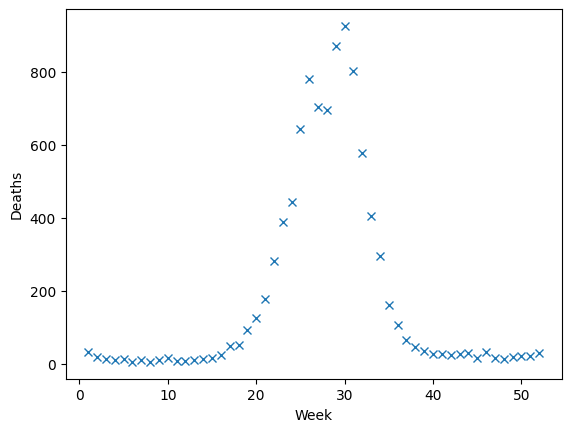

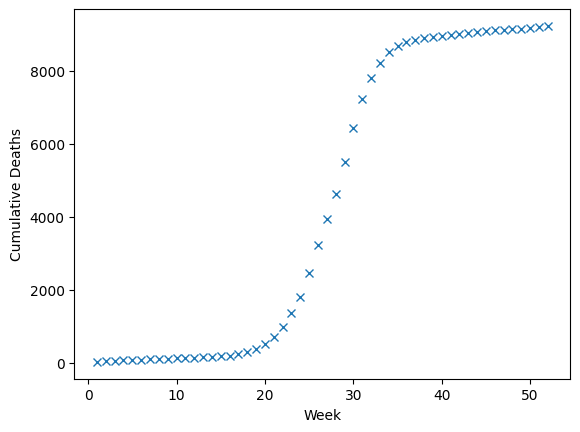

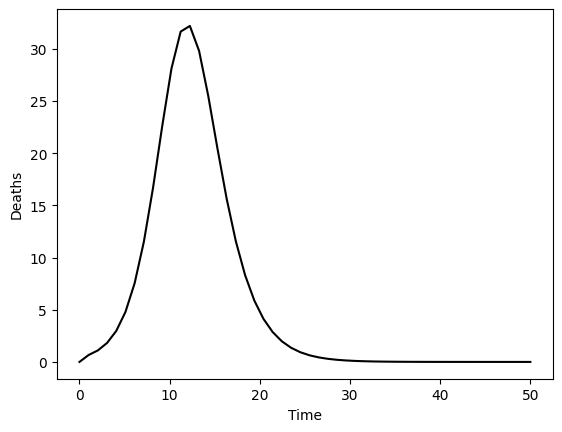

In [3]:
# Load data
df = load_bombay_deaths_data("death2.csv")

# Plot weekly deaths
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(df['week'], df['deaths'], 'x')
ax.set_xlabel('Week')
ax.set_ylabel('Deaths')
plt.show()

# Plot cumulative deaths
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(df['week'], np.cumsum(df['deaths']), 'x')
ax.set_xlabel('Week')
ax.set_ylabel('Cumulative Deaths')
plt.show()


# Make a model object and run a simulation at arbitrary parameter values
m = SIRDModel()
times = np.linspace(0, 50, 50)
params = [1, 1.5, 0.5, 1e3, 1]
y = m.simulate(params, times)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(times, y, color='k')
ax.set_xlabel('Time')
ax.set_ylabel('Deaths')
plt.show()

The results above indicate our ability to load the data and run model simulations at given parameter values. The next step is to find out which parameter values lead to model outputs which are compatible with the data by performing inference. As shown below, this involves a number of challenges which must be addressed carefully.

## Tip 3: Choose an appropriate measurement error model

The measurement error model describes the deviation between the model fit and the data. The IID Gaussian likelihood is a standard choice for this, but we will investigate other options.

First, we perform a preliminary fit using the sum of squared errors objective function. Below, we have also used a rectangular boundaries transformation (see Tip 4).

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Current   Time    
0     8      5346009   5346009    0:00.0
1     16     5283426   5283426    0:00.0
2     24     5279787   5279787    0:00.0
3     32     5279787   5306617    0:00.1
200   1608   122335.5  122443.2   0:03.7
400   3208   113084.7  113090.7   0:07.7
600   4808   109512.8  109525.2   0:11.6
800   6408   108240.4  108240.4   0:15.6
1000  8008   107937.4  107937.4   0:19.5
1200  9608   107867.9  107867.9   0:23.4
1400  11208  107854.3  107854.3   0:27.4
1600  12808  107854.2  107854.2   0:31.4
1694  13552  107854.1  107854.1   0:33.2
Halting: No significant change for 200 iterations.


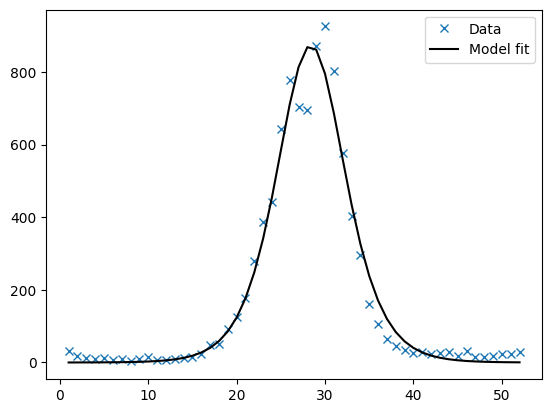

Fit parameters: [1.00000000e+01 1.03921758e+00 1.65472543e-03 7.33837258e+07
 3.82483596e+00]


In [4]:
df = load_bombay_deaths_data("death2.csv")

starting_week = 0

times = df["week"][starting_week:]
y = df["deaths"][starting_week:]

m = SIRDModel()

problem = pints.SingleOutputProblem(m, times, y)
error = pints.SumOfSquaresError(problem)

transformation = pints.RectangularBoundariesTransformation(
    [0.01, 0.1, 0, 1e3, 1],
    [10.0, 10.0, 1.0, 1e8, 10000])

opt = pints.OptimisationController(
    error,
    [0.5, 1.5, 0.5, 1e6, 2],
    method=pints.CMAES,
    transformation=transformation
)
opt.set_log_interval(200)
opt.set_max_unchanged_iterations(200, 1)

found_parameters, found_value = opt.run()

plt.plot(times, y, 'x', label='Data')
plt.plot(times, problem.evaluate(found_parameters), label='Model fit', color='k')
plt.legend()
plt.show()

print("Fit parameters:", found_parameters)

The parameters found by the preliminary fit correspond to a model output that broadly follows the shape of the real data. Next we study the residuals, which are the deviations between the best model fit and the data points.

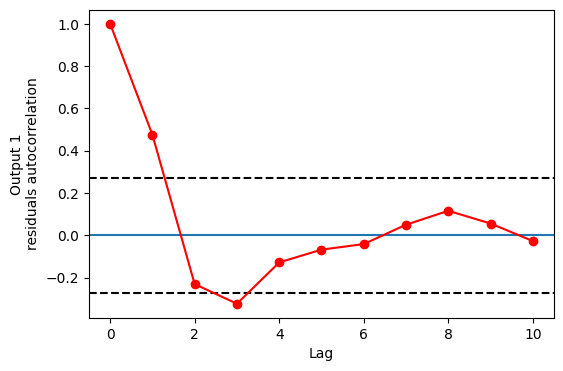

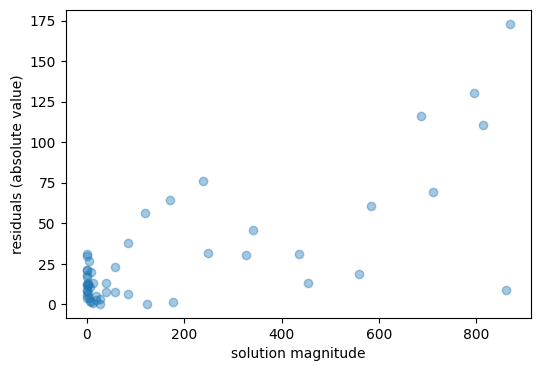

In [5]:
import pints.residuals_diagnostics

pints.residuals_diagnostics.plot_residuals_autocorrelation(np.asarray([found_parameters]), problem)
plt.show()

pints.residuals_diagnostics.plot_residuals_vs_output(np.asarray([found_parameters]), problem)
plt.show()

These diagnostic plots reveal moderate autocorrelation at lag-1, as well as a larger magnitude of noise when the solution magnitude is larger. These results suggest that an assumption of IID noise terms is likely to be incorrect. Instead, we should consider noise models which allow for autocorrelation and heteroscedasticity. 

For example, we may consider using the `pints.AR1LogLikelihood` likelihood in PINTS to account for autocorrelation between consecutive noise terms.

## Tip 4: Consider the parameter space to select transformations, boundaries, and priors

Our model contains five unknown parameters (as well as however many extra parameters are necessary to parametrize the noise process).

Each of the five model parameters has a biological interpretation which will allow us to exclude values which we know are biologically implausible.

1. $k$, which specifies the rate at which individuals leave the infected compartment. Thus, $1/k$ approximates a typical duration for which infectious individuals remain infectious before either dying or recovering. To incorporate this knowledge and exclude implausible values, we will set a uniform prior between 0.05 and 0.5.
2. $R_0$, the basic reproduction number. This represents the number of infectees caused by a single infectious individual in a fully susceptible population. For this parameter, we will assume a uniform distribution between 0.5 and 20.
3. $p$, the probability of dying with the disease. We will assume a uniform prior between 0 and 1.
4. $N$, the total population size. In Bombay at the time of the epidemic this was around 1 million, but, as we observe later in the notebook, this may not be a good value for $N$. To allow for uncertainty in the population size we will assume a uniform prior between 1e3 and 1e8.
5. $I_0$, the number of infectious at the beginning of the simulation. We will assume a uniform distribution between 1 and 1000.

The AR(1) noise likelihood involves two unknown parameters, $\rho$ (which we will assume falls between 0 and 1 with a uniform prior) and $\sigma$ (which we will assume falls between 0 and 1e3, also with a uniform prior).

These parameters vary drastically in their anticipated order of magnitude and have hard constraints, which can present a challenge to certain optimization and sampling algorithms which are attempting to jointly update or sample the parameters. Thus, we will apply a Rectangular Boundaries transformation (available in Pints as `pints.RectangularBoundariesTransformation`). With this transformation, the transformed version ($q$) of each original parameter ($p \in [a, b)$) is given by:

$$q = \log(p-a) - \log(b-p)$$

Then, our inference algorithm will attempt to learn appropriate values of $q \in (-\infty, \infty)$ instead of having to be confined to the original boundaries for each parameter.

It is easy to specify transformations and priors using the classes from PINTS, which we perform below.

In [6]:
transformation = pints.RectangularBoundariesTransformation(
    [0.05, 0.5, 0.0, 1e3, 1, 0.0, 0.0],
    [0.5, 20, 1, 1e8, 100, 1, 1e3]
)

log_prior = pints.UniformLogPrior(
    [0.05, 0.5, 0, 1e3, 1, 0, 0],
    [0.5, 20, 1, 1e8, 100, 1, 1e3]
)

Having selected a likelihood (Tip 3) and defined priors and transformations, we can now run a preliminary optimization fit to maximize the posterior distribution using PINTS.

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 9


Iter. Eval. Best      Current   Time    
0     9     -2062249  -2062249    0:00.0
1     18    -2039415  -2039415    0:00.1
2     27    -2033812  -2033812    0:00.1
3     36    -1979426  -1979426    0:00.1
200   1809  -303.9196 -303.9196   0:01.3
396   3564  -303.9196 -303.9196   0:02.4
Halting: No significant change for 200 iterations.
[2.38465148e-01 1.20189176e+00 4.80066887e-01 4.99994977e+07
 4.85698728e+01 9.58260945e-01 2.51598246e+02]


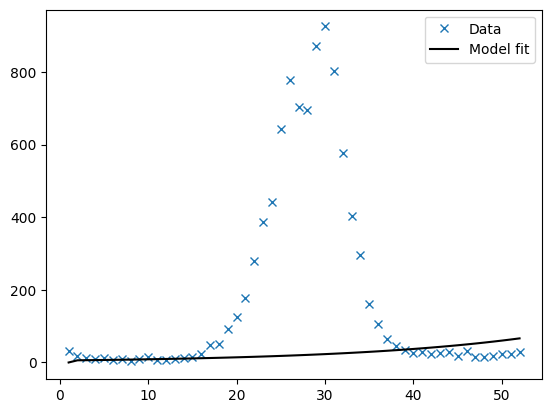

In [7]:
df = load_bombay_deaths_data("death2.csv")
times = df["week"]
y = df["deaths"]

m = SIRDModel()

problem = pints.SingleOutputProblem(m, times, y)

log_likelihood = pints.AR1LogLikelihood(problem)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

opt = pints.OptimisationController(
    log_posterior,
    log_prior.sample(),
    method=pints.CMAES,
    transformation=transformation
)
opt.set_log_interval(200)
found_parameters, found_value = opt.run()

print(found_parameters)

plt.plot(times, y, 'x', label='Data')
plt.plot(times, problem.evaluate(found_parameters[:-2]), label='Model fit', color='k')
plt.legend()
plt.show()


In the figure above, we no longer observe a good fit of the model to the data. In Tips 5, 6, and 7, we will show some steps which can be taken to increase the quality of our inference results.

## Tip 5: Use simulated data analysis and structural and practical identifiability to assess model complexity

An unknown parameter is structurally identifiable if a noise-free observation of the observable model output informs an exact value of the parameter value. Trying to infer an ODE model parameter which is not identifiable is liable to be challenging.

Our full SIRD model as described and implemented above contains five unknown parameters: `k, r0, p, N, init_infected`. We used the SIAN Toolbox (https://maple.cloud/app/6509768948056064/Structural+Identifiability+Toolbox) to assess identifiability of our SIRD model. We inputted the SIRD model with all parameters unknown and only deaths observed using the following code:
```
dS/dt = -k * re * S * In / N,
dIn/dt = k * (re * S * In / N - In),
dD/dt = p * k * In,
y1 = D
```
(Note that the `y1 = D` at the end is how we indicate to the software that the deaths D are observed, `re` refers to $R_0$, and `In` refers to $I$ due to syntax requirements of the software.) Unfortunately, for this system the software indicates that only $k$ is identifiable and the other parameters are not.

Thus, we will not attempt to infer the full parameter vector. Instead, we will use existing knowledge to fix one of the parameters, simplifying the inference problem.

Kermack and McKendrick, "A Contribution to the Mathematical Theory of Epidemics" (1927) states that between 80% and 90% of the cases die. Thus, we will set $p=0.85$, and attempt to learn the four parameters `k, r0, N, init_infected` from the deaths data.

We will continue to use the same simulate method from the full SIRDModel class, while writing a new class to fix the $p$ parameter (See Tip 2).

In [8]:
class SIRDModelKnownP(SIRDModel):
    """SIRD model with p fixed in advance.
    """
    def __init__(self, method="RK45", rtol=1e-6, atol=1e-6, p=0.85):
        super().__init__(method, rtol, atol)
        self.p = p

    def set_p(self, p):
        self.p = p

    def n_parameters(self):
        return 4

    def simulate(self, parameters, times):
        k, r0, N, init_infected = parameters
        return super().simulate((k, r0, self.p, N, init_infected), times)

Simulated data analysis is a good way to investigate practical identifiability. In this approach, we generate synthetic data using known parameter values, add noise until the synthetic data resembles the real data, and then test our ability to recover the known parameter values from the noisy synthetic data.

Visual inspection of the real data shows that there appears to be more noise during weeks when the number of deaths is large. Thus, we will use the `pints.noise.multiplicative_gaussian` noise function to add noise which scales with the magnitude of the output. See also Tip 3 above.

In [9]:
m = SIRDModelKnownP()

times = np.linspace(0, 50, 50)
params = [0.45, 1.5, 5e4, 15]

y = m.simulate(params, times)

y_noisy = y + pints.noise.multiplicative_gaussian(0.5, 3, y)
y_noisy += pints.noise.ar1(0.5, 5, len(y))

Next we assess our ability to recover the parameters which generated the synthetic data using the simple sum of squared errors objective function.

(See Tip 4 for an explanation of the Rectangular Boundaries parameter transformation we use here.)

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Current   Time    
0     8      2.02e+07  2.02e+07   0:00.0
1     16     1.97e+07  1.97e+07   0:00.0
2     24     1.77e+07  1.77e+07   0:00.0
3     32     1.75e+07  1.75e+07   0:00.0
200   1608   72.32542  73.49873   0:01.9
400   3208   4.35e-10  1.06e-09   0:04.1
600   4808   1.08e-21  3.27e-21   0:06.3
617   4936   1.08e-21  2.4e-21    0:06.5
Halting: No significant change for 200 iterations.


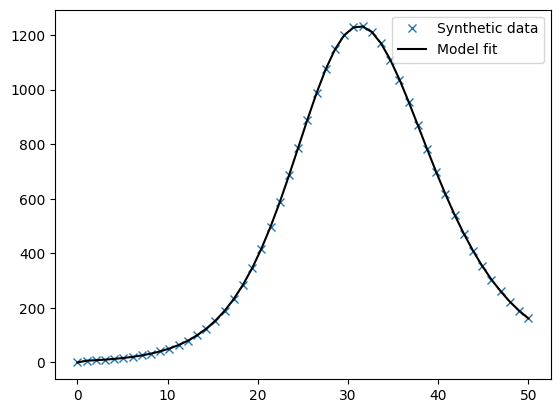

True parameters: [0.45, 1.5, 50000.0, 15]
Fit parameters: [4.5e-01 1.5e+00 5.0e+04 1.5e+01]


In [10]:
problem = pints.SingleOutputProblem(m, times, y)
error = pints.SumOfSquaresError(problem)

transformation = pints.RectangularBoundariesTransformation(
    [0.05, 0.5, 1e4, 1],
    [0.5, 20, 1e8, 100])

opt = pints.OptimisationController(
    error,
    [0.4, 1, 5e5, 2],
    method=pints.CMAES,
    transformation=transformation
)
opt.set_log_interval(200)
found_parameters, found_value = opt.run()


plt.plot(times, y, 'x', label='Synthetic data')
plt.plot(times, problem.evaluate(found_parameters), label='Model fit', color='k')
plt.legend()
plt.show()


print("True parameters:", params)
print("Fit parameters:", found_parameters)

We observe a good fit to the data, and the parameters used to generate the data are recovered. Next, we will try again after adding multiplicative noise to the synthetic model output.

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Current   Time    
0     8      1.82e+07  1.82e+07   0:00.0
1     16     1.73e+07  1.73e+07   0:00.0
2     24     1.73e+07  1.83e+07   0:00.0
3     32     1.73e+07  1.73e+07   0:00.1
200   1608   221062.7  221064.1   0:02.1
400   3208   221038.8  221038.8   0:04.2
600   4808   221038.8  221038.8   0:06.3
800   6408   221038.8  221040.8   0:08.3
817   6536   221038.8  221040.6   0:08.5
Halting: No significant change for 200 iterations.


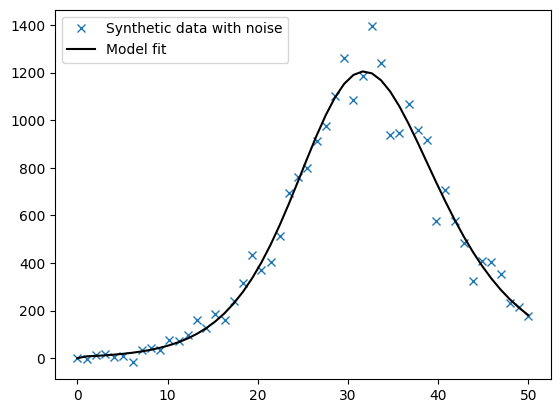

True parameters: [0.45, 1.5, 50000.0, 15]
Fit parameters: [5.00000000e-01 1.42878032e+00 5.49866452e+04 1.59375530e+01]


In [11]:
problem = pints.SingleOutputProblem(m, times, y_noisy)
error = pints.SumOfSquaresError(problem)

opt = pints.OptimisationController(
    error,
    [0.4, 1, 5e5, 2],
    method=pints.CMAES,
    transformation=transformation
)
opt.set_log_interval(200)
found_parameters, found_value = opt.run()


plt.plot(times, y_noisy, 'x', label='Synthetic data with noise')
plt.plot(times, problem.evaluate(found_parameters), label='Model fit', color='k')
plt.legend()
plt.show()


print("True parameters:", params)
print("Fit parameters:", found_parameters)

With noise, the ability to recover the true parameters is impaired, but the recovered values still slightly resemble those used to generate the synthetic data.

## Tip 6: Use an sufficiently accurate solver

Solving the SIRD model at any particular set of parameter values requires numerical approximation of the underlying differential equations. In our implementation, this is handled by the SciPy library `solve_ivp` function (see Tip 2). 

Although this library enables access to powerful ODE solvers (Rk5(4) in our implementation), it is still essential for the user to choose error tolerances that are sufficiently accurate. This can be challenging, as tolerances which are accurate enough for satisfactory forward simulations may not be accurate enough for inference. In other words, even very small errors in forward simulation may interfere with the ability to infer parameters accurately.

The original SIRD model studied in this notebook (see Tip 1) is easy to solve, and does not present a numerical challenge during inference. This may not be the case for many other ODE models, however, including straightforward modifications of the SIRD. 

Our inference results so far---in particular, our preliminary fits and analysis of the residuals (see Tip 3) suggest that the SIRD model is somewhat misspecified to the actual Bombay deaths data. This is evidenced by the strong autocorrelation present in the residuals and the failure of the best model fit obtained so far (Tip 3) to precisely follow the shape of the data. Thus, we may want to consider modifications to the model to improve its ability to fit the data. One possible extension is to allow time variation in model parameters, to allow for the fact that as the disease progresses and time passes, appropriate parameter values to characterize the disease have changed.

Here, we consider an extension to SIRD with one changepoint in the $R_0$ parameter. At some time (not known in advance, and itself to be learned as an unknown parameter), we assume that $R_0$ changes from $R_{0,1}$ to a new value $R_{0, 2}$. We implement this change point model below.




In [12]:
class SIRDModelChangePoint(pints.ForwardModel):
    """Compartmental SIR model with deaths.
    """
    def __init__(self, method="RK45", rtol=1e-6, atol=1e-6):
        """
        Parameters
        ----------
        method : str or scipy solver
            Solver method for solving ODE
        rtol : float
            Relative tolerance of ODE solution (applies to adaptive solvers)
        atol : float
            Absolute tolerance of ODE solution (applies to adaptive solvers)
        """
        super().__init__()
        self.method = method
        self.rtol = rtol
        self.atol = atol
        self.p = 0.85

    def n_parameters(self):
        return 6

    def simulate(self, parameters, times):
        k, r0_0, r0_1, t_change, N, init_infected = parameters
        p = self.p

        def dy(t, y):
            if t < t_change:
                r0 = r0_0
            else:
                r0 = r0_1
            s, i, r, d = y
            ds = -k * r0 * s * i / N
            di = k * (r0 * s * i / N - i)
            dr = (1-p) * k * i
            dd = p * k * i
            return (ds, di, dr, dd)

        initial_condition = np.asarray([N-init_infected, init_infected, 0.0, 0.0])

        res = scipy.integrate.solve_ivp(
            dy,
            (0, max(times)),
            initial_condition,
            t_eval=times,
            rtol=self.rtol,
            atol=self.atol,
            method=self.method)
        
        # Get deaths compartment from the output
        res = res.y.T[:, 3]
        
        # Get change in deaths each week
        res = np.diff(res)
        new_deaths = np.asarray([0] + list(res))
        
        return new_deaths

We now attempt a preliminary fit of this model to the Bombay deaths data, using the sum of squared errors objective function for simplicity.

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 9
Iter. Eval. Best      Current   Time    
0     9      5306256   5306256    0:00.0
1     18     5258573   5258573    0:00.0
2     27     4820111   4820111    0:00.0
3     36     4427465   4427465    0:00.0
200   1809   63292.16  63292.16   0:04.2
400   3609   62319.61  62319.61   0:08.9
600   5409   62319.61  62319.61   0:13.5
742   6678   62319.61  62319.61   0:16.8
Halting: No significant change for 200 iterations.


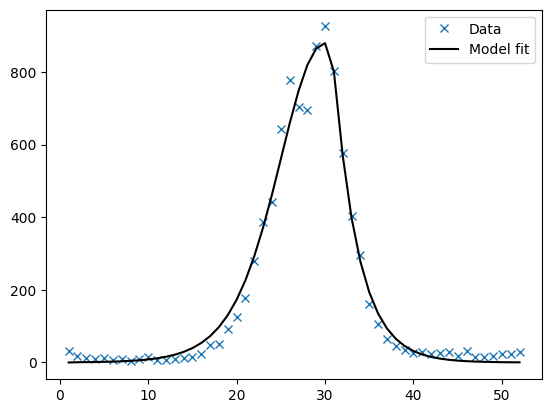

Fit parameters: [5.00000000e-01 1.62836859e+00 5.00000000e-01 3.02976125e+01
 2.39539383e+04 1.00000000e+00]


In [13]:
df = load_bombay_deaths_data("death2.csv")
times = df["week"]
y = df["deaths"]

m = SIRDModelChangePoint()

transformation = pints.RectangularBoundariesTransformation(
    [0.05, 0.5, 0.5, 10, 1e4, 1],
    [0.5, 20, 20, 40, 1e8, 1000]
)

problem = pints.SingleOutputProblem(m, times, y)
error = pints.SumOfSquaresError(problem)


opt = pints.OptimisationController(
    error,
    [0.4, 1, 1, 30, 5e5, 2],
    method=pints.CMAES,
    transformation=transformation
)
opt.set_log_interval(200)
found_parameters, found_value = opt.run()


plt.plot(times, y, 'x', label='Data')
plt.plot(times, problem.evaluate(found_parameters), label='Model fit', color='k')
plt.legend()
plt.show()

print("Fit parameters:", found_parameters)

This model infers a change point at week 30, at which $R_0$ changes from $1.6$ to $0.5$.

To obtain this result, we supplied absolute and relative tolerances of 1e-6 to the ODE solver. Below, we study what might have gone wrong had we used less accurate tolerances, of 1e-2 (which naively might be considered good enough for this simple model). For a range of values of the first $R_0$ value, we compute the objective function for two different choices of tolerances.

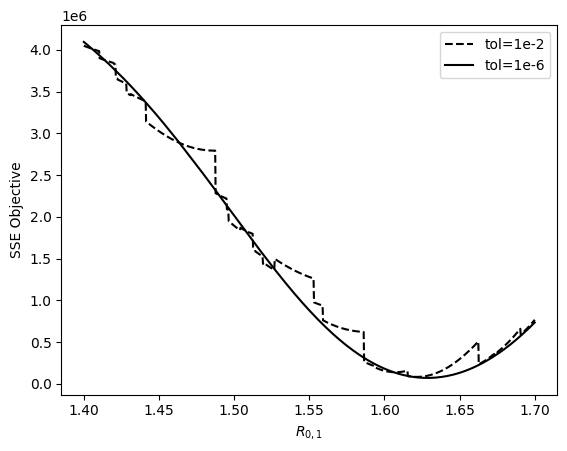

In [14]:
# Compute objective surface for 1e-2 tolerance
m.atol = 1e-2
m.rtol = 1e-2

x_range = np.linspace(1.4, 1.7, 1000) 
errors = []
for x in x_range:
    e = error([0.5, x, .5, 30, 2.4e4, 1])
    errors.append(e)

plt.plot(x_range, errors, label="tol=1e-2", color='k', ls='--')

# Compute the asme objective surface, but with tolerance increasd to 1e-6
m.atol = 1e-6
m.rtol = 1e-6
errors = []
for x in x_range:
    e = error([0.5, x, .5, 30, 2.4e4, 1])
    errors.append(e)

plt.plot(x_range, errors, label="tol=1e-6", color='k', ls='-')
plt.xlabel(r"$R_{0, 1}$")
plt.ylabel("SSE Objective")
plt.legend()
plt.show()

We observe that the 1e-2 tolerance causes a series of significant jagged inaccuracies to appear in the objective surface. These errors arise because different parameter values cause the adaptive ODE solver to select different solver grids at nearby parameter values, and the user-supplied tolerance on the local truncation error fails to guarantee a similar level of accuracy in the objective function or likelihood computed based on the solution (and this effect can be particularly magnified in the presence of a rapid change in the ODE RHS caused by the time variation in $R_0$).

For these reasons, it is essential to select appropriate tolerances when performing inference for ODE models which present numerical challenges, and visualize likelihood or objective functions if possible.

## Tip 7: select an appropriate optimiser and perform many optimisations

To avoid the extra computational expense of computing gradients for a gradient based optimizer, we will rely on the non-gradient based optimizer CMAES. 

Each run of the CMAES optimizer terminates at a parameter value which the optimizer thinks may be locally optimal, but this does not guarantee that it is the best parameter value within the parameter space. One way to ovecome this challenge is to run multiple optimizations. The best fit across multiple runs is more likely to approximate the actual best fit parameters.

Below, we use CMAES to maximize the posterior (assuming AR(1) noise). We repeat the optimizer 20 times, each time initialized at a different location in parameter space.

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 9
Iter. Eval. Best      Current   Time    
0     9     -7.89e+07 -7.89e+07   0:00.0
1     18    -5.77e+07 -5.77e+07   0:00.1
2     27    -3.66e+07 -3.66e+07   0:00.1
3     36    -1.14e+07 -1.14e+07   0:00.1
200   1809  -297.4372 -297.4372   0:03.1
400   3609  -297.4372 -297.4372   0:06.3
457   4113  -297.4372 -297.4372   0:07.3
Halting: No significant change for 200 iterations.
Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 9
Iter. Eval. Best      Current   Time    
0     9     -2.2e+11  -2.2e+11    0:00.0
1     18    -2.01e+11 -2.01e+11   0:00.1
2     27    -1.56e+11 -1.56e+11   0:00.1
3     36    -1.39e+11 -1.39e+11   0:00.2
200   1809  -297.4373 -297.4373   0:03.5
400   3609  -297.4372 -297.4372   0:06.8
477   4293  -297.4372 -297.4372   0:08.0
Halting: No significant change for 20

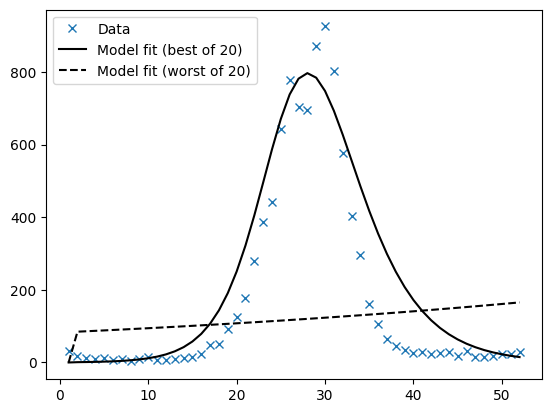

Fit parameters: [4.02600451e-01 1.81364089e+00 1.93601483e+04 1.51876147e+00
 8.16842275e-01 8.36989700e+01]


In [15]:
df = load_bombay_deaths_data("death2.csv")
times = df["week"]
y = df["deaths"]

m = SIRDModelKnownP()


problem = pints.SingleOutputProblem(m, times, y)

error = pints.SumOfSquaresError(problem)

log_likelihood = pints.AR1LogLikelihood(problem)


transformation = pints.RectangularBoundariesTransformation(
    [0.05, 0.5, 1e4, 1, 0, 0],
    [0.5, 20, 1e8, 1000, 1, 100]
)

log_prior = pints.UniformLogPrior(
    [0.05, 0.5, 1e4, 1, 0, 0],
    [0.5, 20, 1e8, 1000, 1, 100]
)

log_posterior = pints.LogPosterior(log_likelihood, log_prior)

num_repeats = 20
best_fit = -np.inf
best_params = None

worst_fit = np.inf
worst_params = None
for _ in range(num_repeats):
    opt = pints.OptimisationController(
        log_posterior,
        log_prior.sample(),
        method=pints.CMAES,
        transformation=transformation
    )
    opt.set_log_interval(200)
    found_parameters, found_value = opt.run()

    if found_value > best_fit:
        best_params = found_parameters
        best_fit = found_value

    if found_value < worst_fit:
        worst_params = found_parameters
        worst_fit = found_value


plt.plot(times, y, 'x', label='Data')
plt.plot(times, problem.evaluate(best_params[:-2]), label='Model fit (best of {})'.format(num_repeats), ls='-', color='k')
plt.plot(times, problem.evaluate(worst_params[:-2]), label='Model fit (worst of {})'.format(num_repeats), ls='--', color='k')
plt.legend()
plt.show()

print("Fit parameters:", best_params)

Across the multiple runs, the best fit approximates the data, but the worst fit has a much lower posterior value and is a poor approximation to the data.

## Tip 8: select appropriate Bayesian inference software and carefully assess convergence

Using the same `log_posterior` object that we defined previously for optimization, we can also using PINTS to infer samples from the posterior distribution using MCMC.

Initially, we will perform inference using a simple random walk Metropolis sampler, with three chains initialized at random samples from the prior distribution.

In [16]:
mcmc = pints.MCMCController(
    log_posterior,
    3,
    log_prior.sample(3),
    transformation=transformation,
    method=pints.MetropolisRandomWalkMCMC
)
mcmc.set_max_iterations(10000)
mcmc.set_log_interval(1000)
chains = mcmc.run()

Using Metropolis random walk MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time    
0     3      0         0         0          0:00.0
1     6      0.5       0         0.5        0:00.0
2     9      0.333     0.333     0.667      0:00.0
3     12     0.25      0.25      0.5        0:00.1
1000  3003   0.548     0.65      0.583      0:06.1
2000  6003   0.417     0.651     0.641      0:10.0
3000  9003   0.332     0.58      0.662      0:14.1
4000  12003  0.291     0.542     0.653      0:18.2
5000  15003  0.263     0.483     0.648      0:22.1
6000  18003  0.243     0.435     0.65       0:26.0
7000  21003  0.23011   0.396     0.653      0:30.1
8000  24003  0.219     0.364     0.655      0:34.1
9000  27003  0.211     0.339     0.659      0:38.2
10000 30000  0.2052    0.3214    0.6652     0:42.2
Halting: Maximum number of iterations (10000) reached.


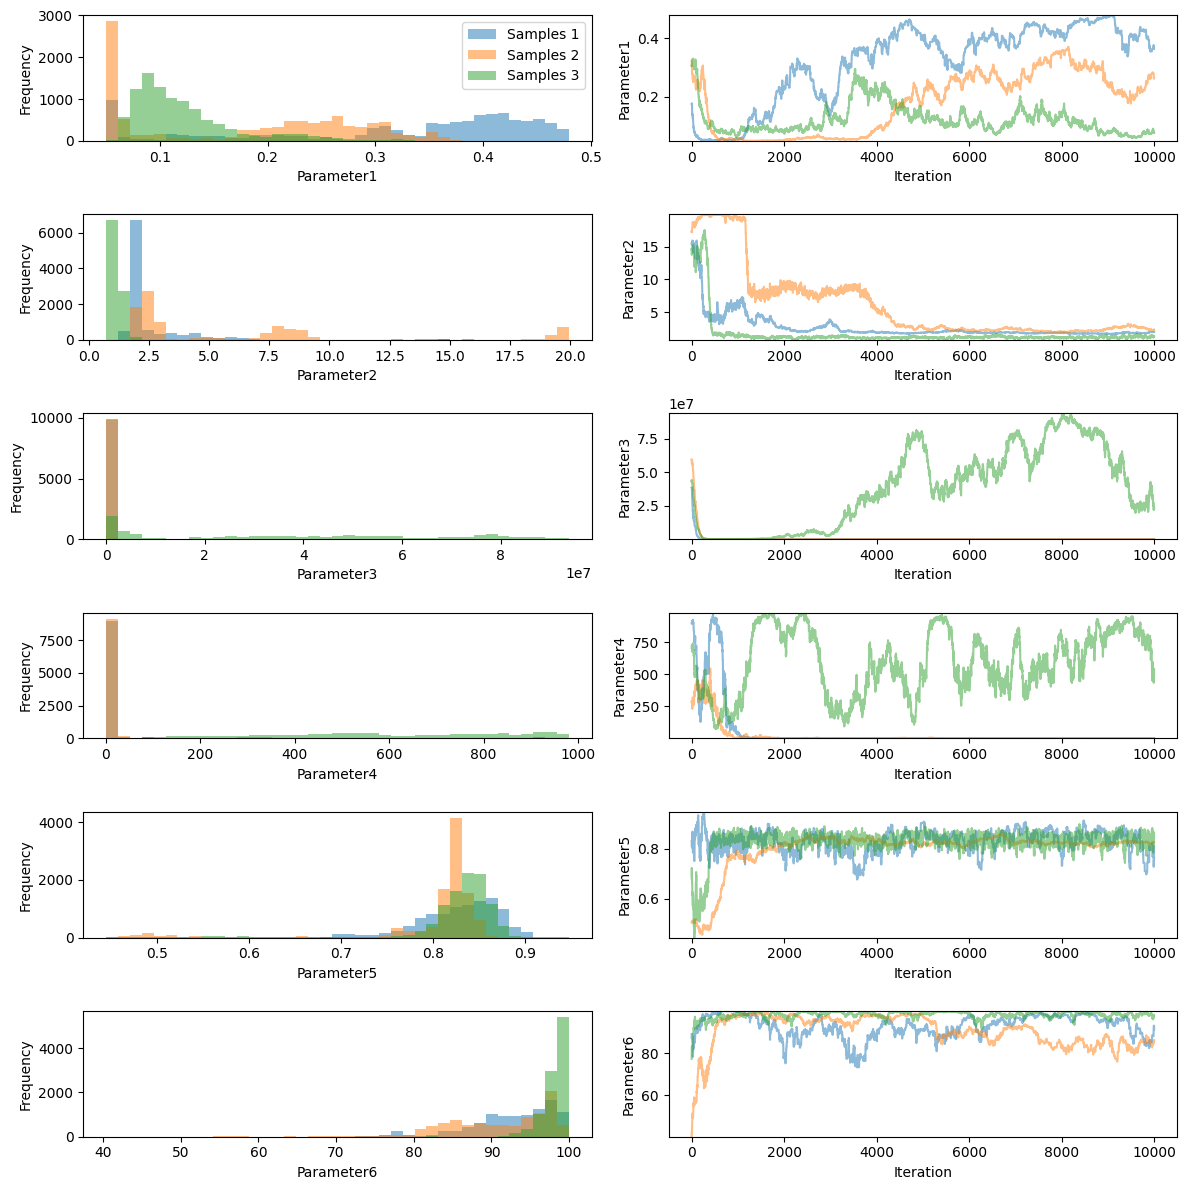

Rhat= [3.83138491 3.15161849 2.95168343 3.71262163 1.03499086 2.17293232]
Effective sample size= [3.7707418599324347, 8.417585702016517, 108.02768657745649, 13.991240979807607, 37.19995255283811, 10.779387253546219]


In [17]:
pints.plot.trace(chains)
plt.show()

rhat = pints.rhat(chains, 0.5)
ess = pints.effective_sample_size(chains[0, :, :])

print("Rhat=", rhat)
print("Effective sample size=", ess)

After 10000 iterations, we observe poor mixing of the three chains in the plot. We also computed $\hat{R}$ values for each parameter, and found them to be siginificantly above 1. Finally, our effetive samples sizes are low for many of the parameters. Thus, the samples obtained above are not representative of the posterior distribution, and such samples should not be used for further analysis.

Next, we will take advantage of the PINTS software to make several improvements to our inference algorithm to try and address these deficiencies. We will switch to the `pints.HaarioBardenetACMC` MCMC sampler, which adaptively tunes the proposal covariance in order to increase efficiency of the sampler. We will continue to run multiple chains to assess convergence, but we will initialize them in the vicinity of the best fit parameter values from our optimization results (Tip 7) due to the inability of the sampler to efficiently reach this location in parameter space when it starts in arbitrary locations (note, that due to this step, if the optimization has failed to reach a posterior mode, our sampling results may be in doubt for this reason as well).

In [18]:
init_params = []
while len(init_params) < 3:
    x = best_params + np.random.normal(0, best_params)
    if log_prior(x) > -np.inf:
        init_params.append(x)

mcmc = pints.MCMCController(
    log_posterior,
    3,
    init_params,
    transformation=transformation,
    method=pints.HaarioBardenetACMC
)
mcmc.set_log_interval(2000)
mcmc.set_max_iterations(40000)
chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval.  Accept.   Accept.   Accept.   Time    
0     3       0         0         0          0:00.0
1     6       0         0.5       0          0:00.0
2     9       0.333     0.333     0.333      0:00.0
3     12      0.5       0.5       0.25       0:00.0
Initial phase completed.
2000  6003    0.235     0.24      0.207      0:08.4
4000  12003   0.226     0.221     0.205      0:16.4
6000  18003   0.222     0.217     0.212      0:24.4
8000  24003   0.223722  0.226     0.215      0:32.3
10000 30003   0.213     0.227     0.215      0:41.0
12000 36003   0.211     0.227     0.219      0:51.8
14000 42003   0.22      0.228     0.219      1:02.6
16000 48003   0.223     0.225     0.223      1:13.4
18000 54003   0.226     0.224     0.225      1:24.5
20000 60003   0.225     0.226     0.227      1:35.3
22000 66003   0.226     0.227     0.227      1:46.2
24000 72003   0.229     0.227     0.229      1:

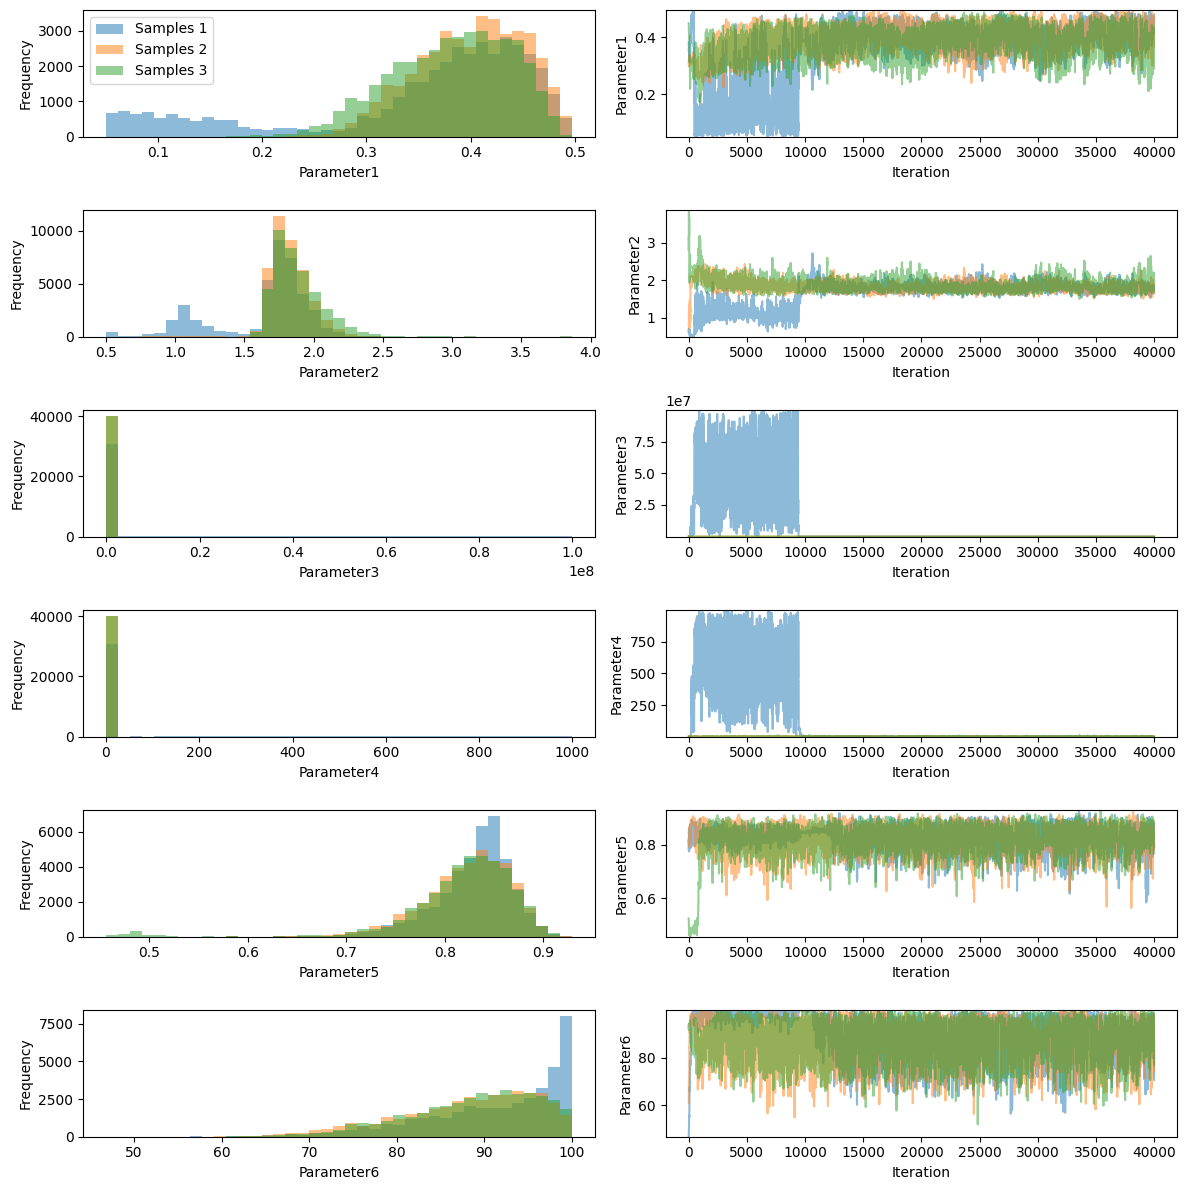

Rhat= [1.03204729 1.03280136 1.00666736 1.0027899  1.00341674 1.00324394]
Effective sample size= [119.83845774385695, 172.42538845395404, 283.8049303170671, 650.9213753052854, 487.4858764691727, 583.2961133927877]


In [19]:
pints.plot.trace(chains)
plt.show()

num_samples = chains.shape[1]
rhat = pints.rhat(chains, 0.5)
ess = pints.effective_sample_size(chains[0, num_samples//2:, :])

print("Rhat=", rhat)
print("Effective sample size=", ess)

Having made these changes to our MCMC procedure, we observe improvements in $\hat{R}$ and effective sample size.

The $R_0$ is around 1.5--2.0. The inferred population size, of around 20000, is well below the actual population of Bombay at the time, which was about 1 million. This may be explained if large fractions of the full Bombay population did not thoroughly mix with the diseased, had prior immunity or resistance to the plague, or fled the city. We inferred a low number of initial infectious. Finally, our results for inferring the noise model parameters show high inferred autocorrelation.

## Tip 9: perform checks of model fit and refine the model as is necessary

To check the model fit from our Bayesian inference results (Tip 8), we will start by plotting the model outputs at the inferred parameter values. This can be done conveniently using the `pints.plot.series`. We will plot every 100th trajectory from the second half of the first chain.

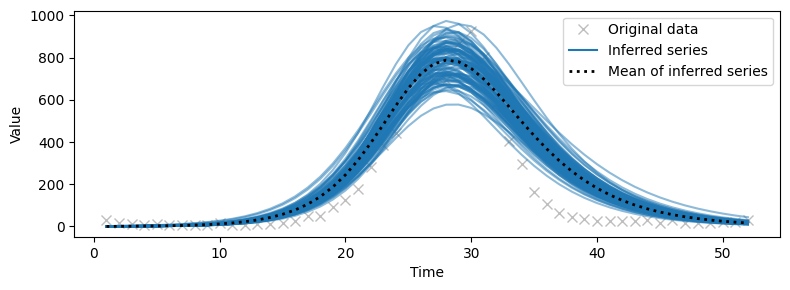

In [20]:
pints.plot.series(chains[0, num_samples//2:, :], problem, thinning=200)
plt.show()

The results show a good fit to the overall shape of the data, but without time regions of significant discrepancy between the model fit and the data, especially around weeks 10--20 and 35--45. This suggests that the model may be somewhat misspecified. Next, we will plot the autocorrelation in the residuals.

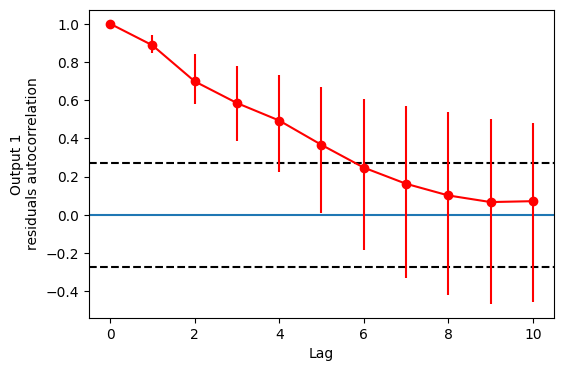

In [21]:
pints.residuals_diagnostics.plot_residuals_autocorrelation(chains[0, num_samples//2:, :], problem, thinning=200)
plt.show()

As expected based on our visualization of the model fits, significant autocorrelation is observed in the residuals.

On the basis of these results, we conclude that the SIRD model is misspecified for the Bombay plague. Refinements to the model to improve the fit could include time variation in model parameters (see Tip 6), extra compartments to represent other disease states, or a change in population size over time (as it is known that many residents of Bombay fled the city while the outbreak was occuring).

However, all of these refinements might make inference more challenging. Our parameter inference results obtained using the simpler model must be interpreted with caution due to the presence of misspecification, but that does not mean they are useless.

## Tip 10: report uncertainties in model outputs and perform sensitivity analyses

The Bayesian inference algorithm used in Tip 10 allows us to estimate the posterior uncertainties in parameter values.

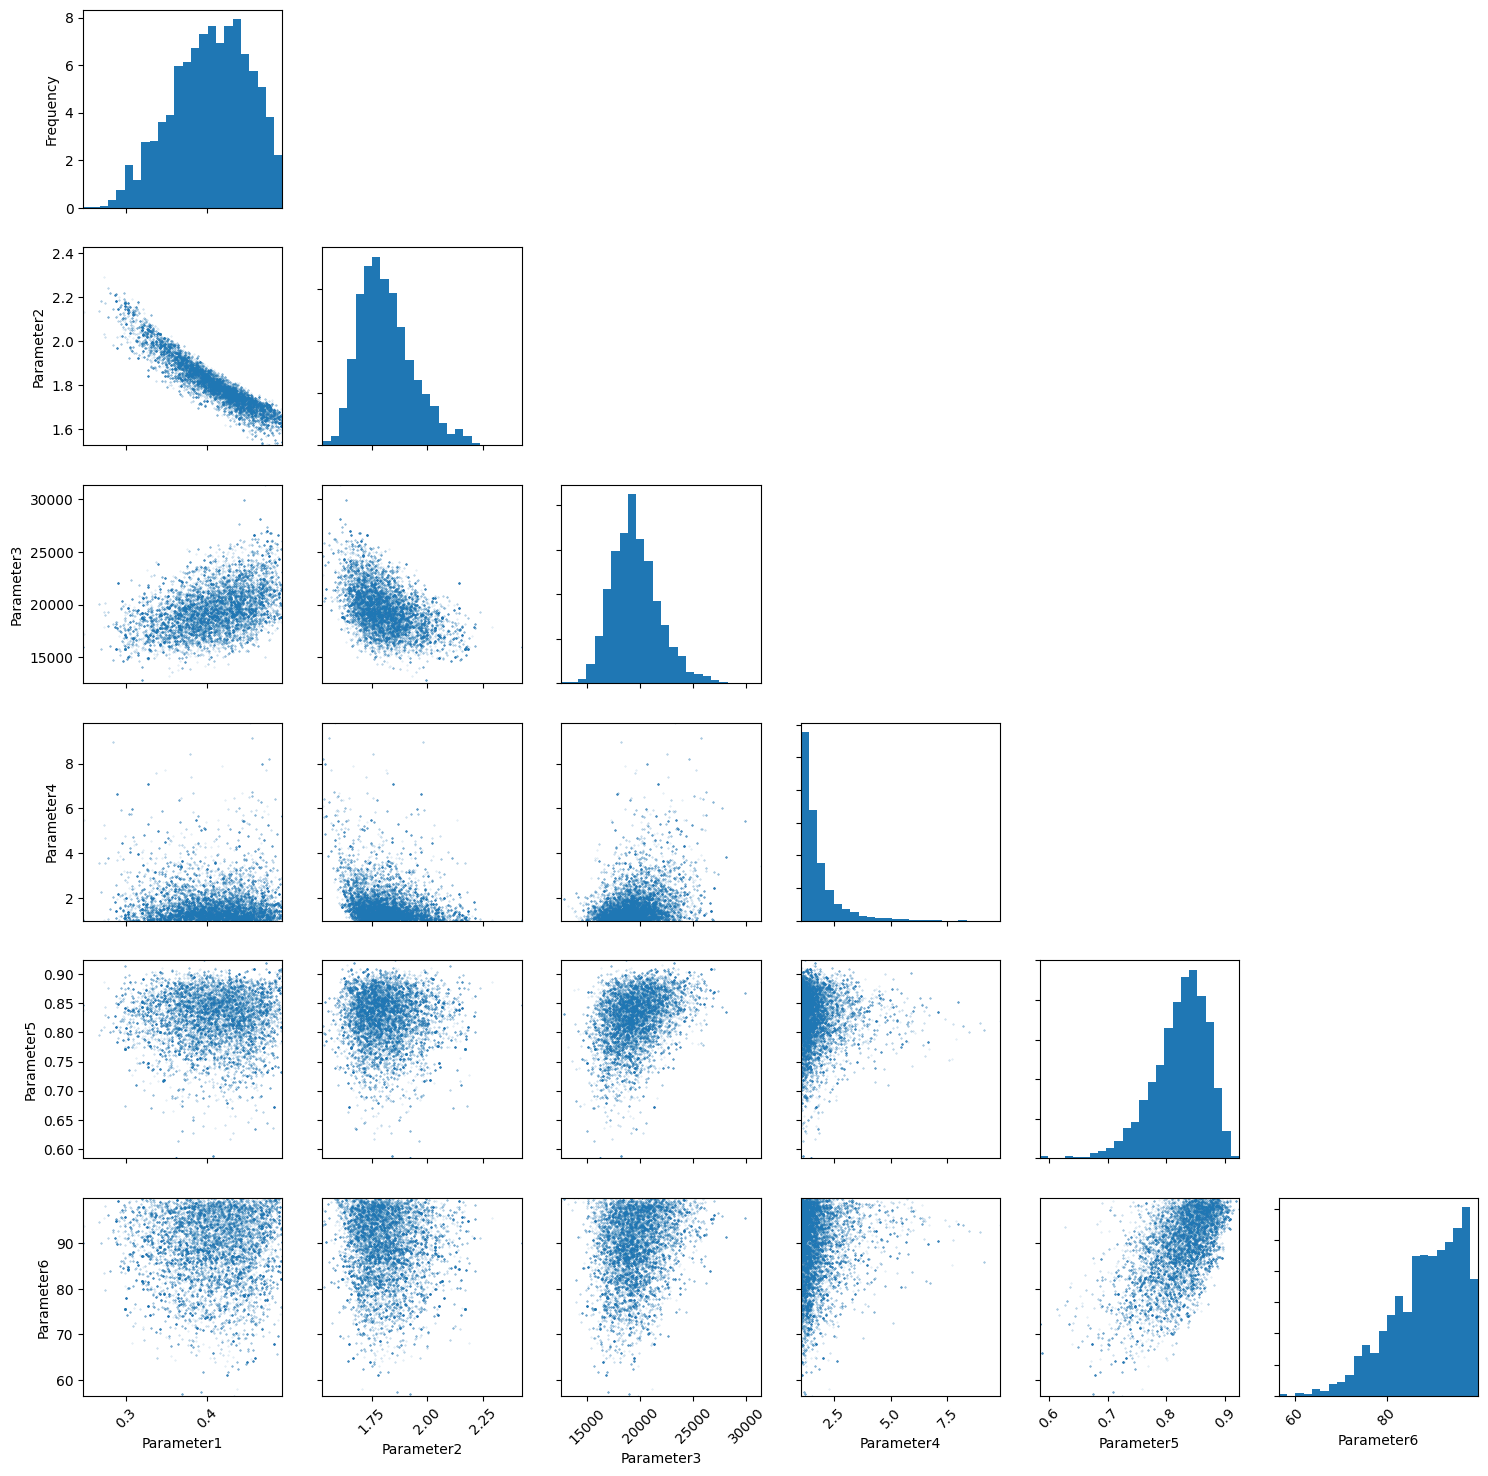

In [22]:
pints.plot.pairwise(chains[0, num_samples//2:, :])
plt.show()

We observe significant posterior uncertainty in all of the inferred parameters. This corresponds to uncertainty in model output, which we observed in Tip 9 when plotting the predicted number of deaths from the fit model.